### Import the Libraries

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [208]:
img_size = 224
image_width = 1024
image_height = 1024

In [3]:
#import pylab as pl
#from glob import glob
#import os
#from matplotlib.patches import Rectangle
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.model_selection import train_test_split
#import tensorflow as tf

In [4]:
#import tensorflow.keras.backend as K
#from tensorflow.keras.models import Model, Sequential
##from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
#from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


#supress warnings
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
det_class_info = 'stage_2_detailed_class_info.csv'
train_bbox = 'stage_2_train_labels.csv'
train_img_dir = 'JPG_train'
test_img_dir = 'JPG_test'

### Pre-Processing, Data Visualization, EDA

#### Loading detailed class info file

In [3]:
class_df = pd.read_csv(det_class_info)

In [4]:
class_df.shape

(30227, 2)

In [5]:
class_df.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [6]:
print(class_df.shape[0], 'class infos loaded')

30227 class infos loaded


In [7]:
print('Total No of Patients', class_df['patientId'].value_counts().shape[0])

Total No of Patients 26684


In [8]:
print('Total distinct classes: ', class_df['class'].unique())

Total distinct classes:  ['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


#### We see there are 3 classes, Normal, Lung Opacity and No Lung Opacity/Not Normal
#### No Lung Opacity/Not Normal are cases that look like opacity but are not. 

#### Check for duplicates in patient id

In [9]:
##Identify duplicates records in the data
dupes = class_df['patientId'].duplicated()
sum(dupes)

3543

#### 3543 patients have multiple X rays

<AxesSubplot:xlabel='class'>

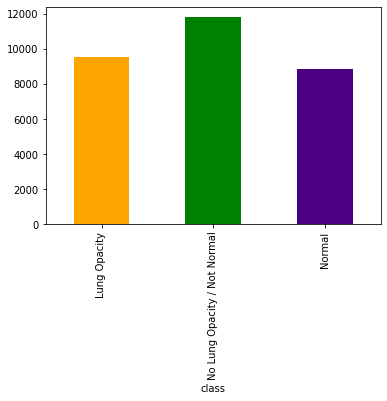

In [10]:
class_df.groupby('class').size().plot.bar(5, 10, color=['Orange', 'green', 'Indigo'])

#### Load CSV file containing training set patientIds and labels (Bounding Boxes)

In [11]:
labels_df = pd.read_csv(train_bbox)

In [12]:
labels_df.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

#### We see patient ids, and bounding box is present in the dataset. 0 means No Pneumonia, 1 means Pneumonia
#### Bounding Box is not present when the patient doesnot have pneumonia, however 0 can mean No Lung Opacity/Not Normal¶

In [13]:
labels_df.shape

(30227, 6)

In [14]:
labels_df['x'] = labels_df['x'].replace(np.nan, 0)
labels_df['y'] = labels_df['y'].replace(np.nan, 0)
labels_df['width'] = labels_df['width'].replace(np.nan, 0)
labels_df['height'] = labels_df['height'].replace(np.nan, 0)

In [15]:
labels_df.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

#### There are 30,227 patient ids

#### Checking the dataset information

In [16]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          30227 non-null  float64
 2   y          30227 non-null  float64
 3   width      30227 non-null  float64
 4   height     30227 non-null  float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [17]:
labels_df.describe()

x             y         width        height        Target
count  30227.000000  30227.000000  30227.000000  30227.000000  30227.000000
mean     124.561683    115.960962     69.060575    104.084825      0.316108
std      216.326397    190.012883    106.910496    176.932152      0.464963
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000      0.000000      0.000000
75%      193.000000    231.000000    169.000000    188.000000      1.000000
max      835.000000    881.000000    528.000000    942.000000      1.000000

#### Checking duplicates if it matches with class info file

In [249]:
##Identify duplicates records in the data
dupes = labels_df['patientId'].duplicated()
sum(dupes)

3543

In [251]:
dupes.head()

0    False
1    False
2    False
3    False
4    False
Name: patientId, dtype: bool

#### 3543 patients have multiple X rays

#### Check for missing values

In [19]:
print(" \nCount total NaN at each column in the dataset : \n\n", 
      labels_df.isnull().sum())

 
Count total NaN at each column in the dataset : 

 patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64


#### From the above only columns x, y, width, height is having null
#### This is fine since bounding box can be null if there is no pneumonia

#### Let's read the training data in the stage_2_train_images folder
#### We will use pydicom library, the patient id in stage_2_train_labels.csv file will have a file with patientid.dcm

In [20]:
patientDetails_df = pd.read_csv('Patient_Detail.csv')

In [21]:
patientDetails_df.head()

SpecificCharacterSet                      SOPClassUID  \
0           ISO_IR 100  Secondary Capture Image Storage   
1           ISO_IR 100  Secondary Capture Image Storage   
2           ISO_IR 100  Secondary Capture Image Storage   
3           ISO_IR 100  Secondary Capture Image Storage   
4           ISO_IR 100  Secondary Capture Image Storage   

                                      SOPInstanceUID  StudyDate  StudyTime  \
0  1.2.276.0.7230010.3.1.4.8323329.27517.15178744...   19010101          0   
1  1.2.276.0.7230010.3.1.4.8323329.23588.15178744...   19010101          0   
2  1.2.276.0.7230010.3.1.4.8323329.8058.151787433...   19010101          0   
3  1.2.276.0.7230010.3.1.4.8323329.20441.15178744...   19010101          0   
4  1.2.276.0.7230010.3.1.4.8323329.17546.15178744...   19010101          0   

   AccessionNumber Modality ConversionType  ReferringPhysicianName  \
0              NaN       CR            WSD                     NaN   
1              NaN       CR            WSD                     NaN   
2              NaN       CR            WSD                     NaN   
3              NaN       CR            WSD                     NaN   
4              NaN       CR            WSD                     NaN   

  SeriesDescription  ...  Rows Columns  \
0          view: PA  ...  1024    1024   
1          view: PA  ...  1024    1024   
2          view: AP  ...  1024    1024   
3          view: PA  ...  1024    1024   
4          view: AP  ...  1024    1024   

                                 PixelSpacing BitsAllocated  BitsStored  \
0  [0.14300000000000002, 0.14300000000000002]             8           8   
1  [0.14300000000000002, 0.14300000000000002]             8           8   
2                              [0.168, 0.168]             8           8   
3  [0.14300000000000002, 0.14300000000000002]             8           8   
4                              [0.168, 0.168]             8           8   

  HighBit PixelRepresentation LossyImageCompression  \
0       7                   0                     1   
1       7                   0                     1   
2       7                   0                     1   
3       7                   0                     1   
4       7                   0                     1   

  LossyImageCompressionMethod                 PixelData  
0                 ISO_10918_1  Array of 148424 elements  
1                 ISO_10918_1  Array of 162472 elements  
2                 ISO_10918_1  Array of 113272 elements  
3                 ISO_10918_1  Array of 172698 elements  
4                 ISO_10918_1  Array of 113882 elements  

[5 rows x 35 columns]

In [22]:
patientDetails_df.columns

Index(['SpecificCharacterSet', 'SOPClassUID', 'SOPInstanceUID', 'StudyDate',
       'StudyTime', 'AccessionNumber', 'Modality', 'ConversionType',
       'ReferringPhysicianName', 'SeriesDescription', 'PatientName',
       'PatientID', 'PatientBirthDate', 'PatientSex', 'PatientAge',
       'BodyPartExamined', 'ViewPosition', 'StudyInstanceUID',
       'SeriesInstanceUID', 'StudyID', 'SeriesNumber', 'InstanceNumber',
       'PatientOrientation', 'SamplesperPixel', 'PhotometricInterpretation',
       'Rows', 'Columns', 'PixelSpacing', 'BitsAllocated', 'BitsStored',
       'HighBit', 'PixelRepresentation', 'LossyImageCompression',
       'LossyImageCompressionMethod', 'PixelData'],
      dtype='object')

In [23]:
patientDetails_df.loc[patientDetails_df['PatientID'] == labels_df['patientId'][10]]

SpecificCharacterSet                      SOPClassUID  \
15858           ISO_IR 100  Secondary Capture Image Storage   

                                          SOPInstanceUID  StudyDate  \
15858  1.2.276.0.7230010.3.1.4.8323329.17654.15178744...   19010101   

       StudyTime  AccessionNumber Modality ConversionType  \
15858          0              NaN       CR            WSD   

       ReferringPhysicianName SeriesDescription  ...  Rows Columns  \
15858                     NaN          view: PA  ...  1024    1024   

                                     PixelSpacing BitsAllocated  BitsStored  \
15858  [0.19431099999999998, 0.19431099999999998]             8           8   

      HighBit PixelRepresentation LossyImageCompression  \
15858       7                   0                     1   

      LossyImageCompressionMethod                 PixelData  
15858                 ISO_10918_1  Array of 116624 elements  

[1 rows x 35 columns]

In [24]:
def checkXray(i, dirName):
    patientId = labels_df['patientId'][i]
    print("Patient Id: ", patientId)
    fileName = dirName + "/" + patientId + ".jpg"
    
    print("\nBounding Box Coordinates, X: ", labels_df['x'][i])
    print("\nBounding Box Coordinates, Y: ", labels_df['y'][i])
    print("\nBounding Box Coordinates, Width: ", labels_df['width'][i])
    print("\nBounding Box Coordinates, Height: ", labels_df['height'][i])
    
    print("\nPatient Details below: ")
    display(patientDetails_df.loc[patientDetails_df['PatientID'] == patientId])
    
    img = cv2.imread(fileName)
    plt.imshow(img)
    plt.show()

#### Let's take a look into an image of a person who has normal lungs

Patient Id:  003d8fa0-6bf1-40ed-b54c-ac657f8495c5

Bounding Box Coordinates, X:  0.0

Bounding Box Coordinates, Y:  0.0

Bounding Box Coordinates, Width:  0.0

Bounding Box Coordinates, Height:  0.0

Patient Details below: 


SpecificCharacterSet                      SOPClassUID  \
8359           ISO_IR 100  Secondary Capture Image Storage   

                                         SOPInstanceUID  StudyDate  StudyTime  \
8359  1.2.276.0.7230010.3.1.4.8323329.2293.151787429...   19010101          0   

      AccessionNumber Modality ConversionType  ReferringPhysicianName  \
8359              NaN       CR            WSD                     NaN   

     SeriesDescription  ...  Rows Columns  \
8359          view: PA  ...  1024    1024   

                                    PixelSpacing BitsAllocated  BitsStored  \
8359  [0.14300000000000002, 0.14300000000000002]             8           8   

     HighBit PixelRepresentation LossyImageCompression  \
8359       7                   0                     1   

     LossyImageCompressionMethod                 PixelData  
8359                 ISO_10918_1  Array of 155284 elements  

[1 rows x 35 columns]

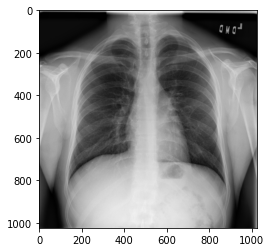

In [25]:
checkXray(3, train_img_dir)

#### Let's take a look into an image of a person who has lung opacity

Patient Id:  00436515-870c-4b36-a041-de91049b9ab4

Bounding Box Coordinates, X:  264.0

Bounding Box Coordinates, Y:  152.0

Bounding Box Coordinates, Width:  213.0

Bounding Box Coordinates, Height:  379.0

Patient Details below: 


SpecificCharacterSet                      SOPClassUID  \
10212           ISO_IR 100  Secondary Capture Image Storage   

                                          SOPInstanceUID  StudyDate  \
10212  1.2.276.0.7230010.3.1.4.8323329.6379.151787432...   19010101   

       StudyTime  AccessionNumber Modality ConversionType  \
10212          0              NaN       CR            WSD   

       ReferringPhysicianName SeriesDescription  ...  Rows Columns  \
10212                     NaN          view: AP  ...  1024    1024   

         PixelSpacing BitsAllocated  BitsStored HighBit PixelRepresentation  \
10212  [0.139, 0.139]             8           8       7                   0   

      LossyImageCompression LossyImageCompressionMethod  \
10212                     1                 ISO_10918_1   

                      PixelData  
10212  Array of 119382 elements  

[1 rows x 35 columns]

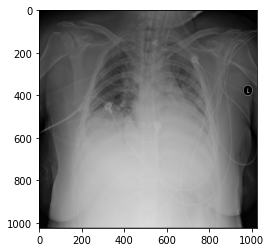

In [26]:
checkXray(4, train_img_dir)

#### The images contain combination of header metadata as well as underlying raw image arrays for pixel data

#### Let's take a look into an image of a person who has No Lung Opacity/Not Normal¶

Patient Id:  0004cfab-14fd-4e49-80ba-63a80b6bddd6

Bounding Box Coordinates, X:  0.0

Bounding Box Coordinates, Y:  0.0

Bounding Box Coordinates, Width:  0.0

Bounding Box Coordinates, Height:  0.0

Patient Details below: 


SpecificCharacterSet                      SOPClassUID  \
7634           ISO_IR 100  Secondary Capture Image Storage   

                                         SOPInstanceUID  StudyDate  StudyTime  \
7634  1.2.276.0.7230010.3.1.4.8323329.28530.15178744...   19010101          0   

      AccessionNumber Modality ConversionType  ReferringPhysicianName  \
7634              NaN       CR            WSD                     NaN   

     SeriesDescription  ...  Rows Columns  \
7634          view: PA  ...  1024    1024   

                                    PixelSpacing BitsAllocated  BitsStored  \
7634  [0.14300000000000002, 0.14300000000000002]             8           8   

     HighBit PixelRepresentation LossyImageCompression  \
7634       7                   0                     1   

     LossyImageCompressionMethod                 PixelData  
7634                 ISO_10918_1  Array of 142006 elements  

[1 rows x 35 columns]

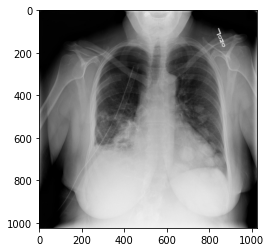

In [27]:
checkXray(0, train_img_dir)

#### Joining Train Label and Class Info data set so that we have one consolidated dataset

In [28]:
labels_class_df = pd.merge(labels_df, class_df, how='inner', on='patientId')
print('Total Cases : ', labels_class_df.shape[0])

Total Cases :  37629


#### Since there are duplicate patient ids in both the datasets we see an increase in the number of rows
#### Instead of doing inner join lets try to concat both the datasets

In [29]:
labels_class_df = pd.concat([labels_df, class_df.drop('patientId',1)], 1)
print('Total Cases : ', labels_class_df.shape[0])
labels_class_df.head(10)

Total Cases :  30227


patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
6  00569f44-917d-4c86-a842-81832af98c30    0.0    0.0    0.0     0.0       0   
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    0.0    0.0    0.0     0.0       0   
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1   
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  
5                  Lung Opacity  
6  No Lung Opacity / Not Normal  
7  No Lung Opacity / Not Normal  
8                  Lung Opacity  
9                  Lung Opacity

### We will check the number of boxes for each patient

In [30]:
box_patient_df = labels_class_df.groupby('patientId').size().reset_index(name='boxes')

In [31]:
box_patient_df.head()

patientId  boxes
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6      1
1  000924cf-0f8d-42bd-9158-1af53881a557      1
2  000db696-cf54-4385-b10b-6b16fbb3f985      2
3  000fe35a-2649-43d4-b027-e67796d412e0      2
4  001031d9-f904-4a23-b3e5-2c088acd19c6      2

In [66]:
box_patient_df.groupby('boxes').size().reset_index(name='patients')

boxes  patients
0      1     23286
1      2      3266
2      3       119
3      4        13

#### Let's check the types of the categories of the classes

In [67]:
labels_class_df.groupby(['class']).size().reset_index(name='Patient Count')

class  Patient Count
0                  Lung Opacity           9555
1  No Lung Opacity / Not Normal          11821
2                        Normal           8851

In [68]:
labels_class_df.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

In [97]:
labels_class_merge_df = pd.merge(labels_class_df, box_patient_df, on='patientId')

In [98]:
labels_class_merge_df.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    0.0    0.0    0.0     0.0       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    0.0    0.0    0.0     0.0       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    0.0    0.0    0.0     0.0       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  boxes  
0  No Lung Opacity / Not Normal      1  
1  No Lung Opacity / Not Normal      1  
2  No Lung Opacity / Not Normal      1  
3                        Normal      1  
4                  Lung Opacity      2

#### Create Train image dataframe

In [71]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [255]:
def get_image_data(data_dir, img_size):
    count = 0
    image_df = pd.DataFrame(columns=['patientId', 'path', 'imageArray'])
    for img in os.listdir(data_dir):
        ptntId = img.split(".", 1)[0]
        fileName = data_dir + "/" + ptntId + ".jpg"
        if count % 100 == 0:
            print('{} image converted'.format(count))
        try:
            img_arr = load_image(os.path.join(data_dir, img))
            img_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
            # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
            #img_arr = (img_arr / 255.).astype(np.float32)
            img_arr = preprocess_input(np.array(img_arr, dtype=np.float32))
            image_df.loc[count] = [ptntId , fileName, img_arr]
        except Exception as e:
            print(e)
        count = count + 1

    return image_df

In [ ]:
image_train_df = get_image_data(train_img_dir, 224)

0 image converted
100 image converted
200 image converted
300 image converted
400 image converted
500 image converted
600 image converted
700 image converted
800 image converted
900 image converted
1000 image converted
1100 image converted
1200 image converted
1300 image converted
1400 image converted
1500 image converted
1600 image converted
1700 image converted
1800 image converted
1900 image converted
2000 image converted
2100 image converted
2200 image converted
2300 image converted
2400 image converted
2500 image converted
2600 image converted
2700 image converted
2800 image converted
2900 image converted
3000 image converted
3100 image converted
3200 image converted
3300 image converted
3400 image converted
3500 image converted
3600 image converted
3700 image converted
3800 image converted
3900 image converted
4000 image converted
4100 image converted
4200 image converted
4300 image converted
4400 image converted
4500 image converted
4600 image converted
4700 image converted
4800

In [38]:
# saving the dataframe 
#image_train_df.to_csv('file1.csv')

In [94]:
image_train_df = pd.read_csv('file1.csv')

In [95]:
image_train_df.shape

(26684, 3)

In [248]:
image_train_df.head(5)

patientId  \
0  f93d9a23-cc0d-4eff-abf1-62139ebe80d9   

                                                path  \
0  JPG_train/f93d9a23-cc0d-4eff-abf1-62139ebe80d9...   

                                          imageArray  
0  [[[-0.15294117, -0.15294117, -0.15294117], [-0...

#### Join Image path details and Class Label details on the basis of patient ids

In [99]:
labels_class_merge_df = pd.merge(labels_class_merge_df, 
                         image_train_df, 
                         on='patientId',
                        how='left').sort_values('patientId')
print(labels_class_merge_df.shape[0], 'image bounding boxes')
labels_class_merge_df.head(5)

30227 image bounding boxes


patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0   
28989  000924cf-0f8d-42bd-9158-1af53881a557    0.0    0.0    0.0     0.0   
28990  000db696-cf54-4385-b10b-6b16fbb3f985  316.0  318.0  170.0   478.0   
28991  000db696-cf54-4385-b10b-6b16fbb3f985  660.0  375.0  146.0   402.0   
28992  000fe35a-2649-43d4-b027-e67796d412e0  570.0  282.0  269.0   409.0   

       Target                         class  boxes  \
0           0  No Lung Opacity / Not Normal      1   
28989       0                        Normal      1   
28990       1                  Lung Opacity      2   
28991       1                  Lung Opacity      2   
28992       1                  Lung Opacity      2   

                                                    path  \
0      JPG_train/0004cfab-14fd-4e49-80ba-63a80b6bddd6...   
28989  JPG_train/000924cf-0f8d-42bd-9158-1af53881a557...   
28990  JPG_train/000db696-cf54-4385-b10b-6b16fbb3f985...   
28991  JPG_train/000db696-cf54-4385-b10b-6b16fbb3f985...   
28992  JPG_train/000fe35a-2649-43d4-b027-e67796d412e0...   

                                              imageArray  
0      [[[3.25770319e-01 3.25770319e-01 3.25770319e-0...  
28989  [[[0. 0. 0.]\n  [0. 0. 0.]\n  [0. 0. 0.]\n  .....  
28990  [[[0.01092437 0.01092437 0.01092437]\n  [0.011...  
28991  [[[0.01092437 0.01092437 0.01092437]\n  [0.011...  
28992  [[[6.2845141e-02 6.2845141e-02 6.2845141e-02]\...

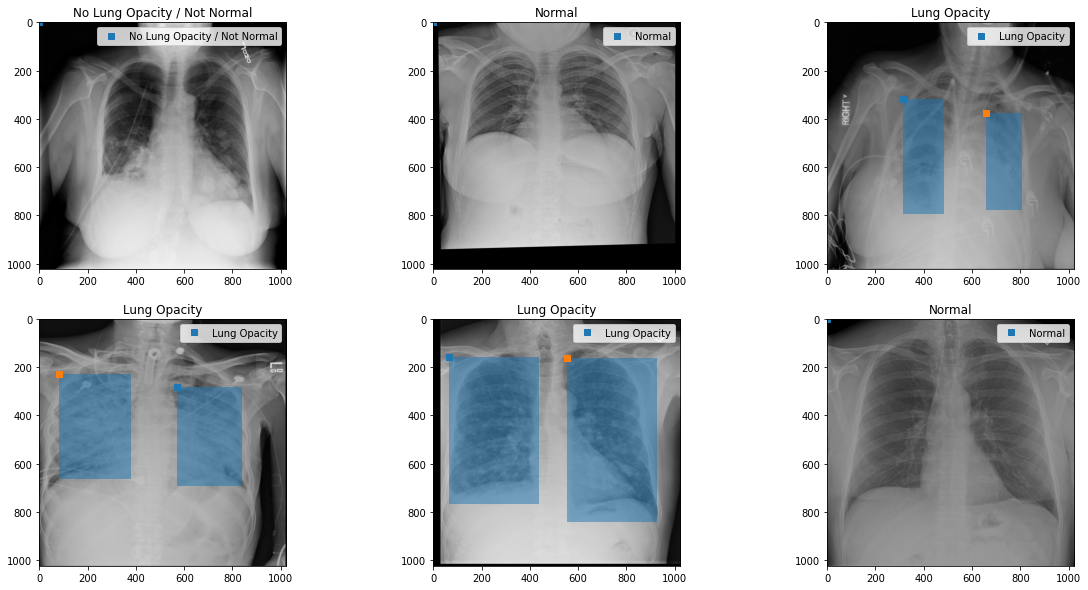

In [100]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(), labels_class_merge_df.groupby(['path'])):
    c_dicom = load_image(c_path)
    c_ax.imshow(c_dicom, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']), width=c_row['width'],height=c_row['height'],alpha = 0.5))
        if i==0: c_ax.legend()
    

In [101]:
# get the labels in the right format
class_enc = LabelEncoder()
labels_class_merge_df['class_value'] = class_enc.fit_transform(labels_class_merge_df['class'])

In [190]:
labels_class_merge_df.head()

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    0.0    0.0    0.0     0.0   
28989  000924cf-0f8d-42bd-9158-1af53881a557    0.0    0.0    0.0     0.0   
28990  000db696-cf54-4385-b10b-6b16fbb3f985  316.0  318.0  170.0   478.0   
28991  000db696-cf54-4385-b10b-6b16fbb3f985  660.0  375.0  146.0   402.0   
28992  000fe35a-2649-43d4-b027-e67796d412e0  570.0  282.0  269.0   409.0   

       Target                         class  boxes  \
0           0  No Lung Opacity / Not Normal      1   
28989       0                        Normal      1   
28990       1                  Lung Opacity      2   
28991       1                  Lung Opacity      2   
28992       1                  Lung Opacity      2   

                                                    path  \
0      JPG_train/0004cfab-14fd-4e49-80ba-63a80b6bddd6...   
28989  JPG_train/000924cf-0f8d-42bd-9158-1af53881a557...   
28990  JPG_train/000db696-cf54-4385-b10b-6b16fbb3f985...   
28991  JPG_train/000db696-cf54-4385-b10b-6b16fbb3f985...   
28992  JPG_train/000fe35a-2649-43d4-b027-e67796d412e0...   

                                              imageArray  class_value  
0      [[[3.25770319e-01 3.25770319e-01 3.25770319e-0...            1  
28989  [[[0. 0. 0.]\n  [0. 0. 0.]\n  [0. 0. 0.]\n  .....            2  
28990  [[[0.01092437 0.01092437 0.01092437]\n  [0.011...            0  
28991  [[[0.01092437 0.01092437 0.01092437]\n  [0.011...            0  
28992  [[[6.2845141e-02 6.2845141e-02 6.2845141e-02]\...            0

### 0  = Lung Opacity
### 1 = No Lung Opacity / Not Normal
### 2 = Normal

### Split features in to train and validation

In [252]:
X = np.zeros((int(labels_class_merge_df.shape[0]), image_height, image_width, 3))
y = np.zeros((labels_class_merge_df.shape[0], 4))
for index in range(labels_class_merge_df.shape[0]):
    
    img = labels_class_merge_df['imageArray'][index]
    #print(img)
    try:
        X[index] = preprocess_input(np.array(img, dtype=np.float32))
    except Exception as e:
        print(e)
        continue
    
    x0 = labels_class_merge_df['x'][index]
    y0 = labels_class_merge_df['y'][index]
    x1 = labels_class_merge_df['width'][index]
    y1 = labels_class_merge_df['height'][index]
    
    print(x0)
    
    y[index, 0] = x0 * img_size / image_width                 # Normalize bounding box by image size
    y[index, 1] = y0 * img_size / image_height                # Normalize bounding box by image size
    y[index, 2] = (x1 - x0) * img_size / image_width          # Normalize bounding box by image size
    y[index, 3] = (y1 - y0) * img_size / image_height         # Normalize bounding box by image size
    
    region = y[index]

    #x0 = int(region[0] * image_width / img_size) # Scale the BBox
    #y0 = int(region[1] * image_height / img_size)

    #x1 = int((region[0] + region[2]) * image_width / img_size) #original boox/unscaled
    #y1 = int((region[1] + region[3]) * image_height / img_size)

could not convert string to float: '[[[3.25770319e-01 3.25770319e-01 3.25770319e-01]\n  [1.55462191e-01 1.55462191e-01 1.55462191e-01]\n  [8.29731897e-02 8.29731897e-02 8.29731897e-02]\n  ...\n  [2.61004418e-01 2.61004418e-01 2.61004418e-01]\n  [4.37034816e-01 4.37034816e-01 4.37034816e-01]\n  [6.62384987e-01 6.62384987e-01 6.62384987e-01]]\n\n [[9.32573080e-02 9.32573080e-02 9.32573080e-02]\n  [3.03121265e-02 3.03121265e-02 3.03121265e-02]\n  [9.52380989e-03 9.52380989e-03 9.52380989e-03]\n  ...\n  [4.72388975e-02 4.72388975e-02 4.72388975e-02]\n  [1.51700690e-01 1.51700690e-01 1.51700690e-01]\n  [4.28331345e-01 4.28331345e-01 4.28331345e-01]]\n\n [[1.77070834e-02 1.77070834e-02 1.77070834e-02]\n  [1.17647061e-02 1.17647061e-02 1.17647061e-02]\n  [7.84313772e-03 7.84313772e-03 7.84313772e-03]\n  ...\n  [2.00080103e-05 2.00080103e-05 2.00080103e-05]\n  [2.69707888e-02 2.69707888e-02 2.69707888e-02]\n  [1.58723503e-01 1.58723503e-01 1.58723503e-01]]\n\n ...\n\n [[2.07282919e-02 2.072829

could not convert string to float: '[[[0.27086836 0.27086836 0.27086836]\n  [0.0812325  0.0812325  0.0812325 ]\n  [0.00532213 0.00532213 0.00532213]\n  ...\n  [0.00582233 0.00582233 0.00582233]\n  [0.00866347 0.00866347 0.00866347]\n  [0.03371349 0.03371349 0.03371349]]\n\n [[0.25826332 0.25826332 0.25826332]\n  [0.0789916  0.0789916  0.0789916 ]\n  [0.00420168 0.00420168 0.00420168]\n  ...\n  [0.         0.         0.        ]\n  [0.         0.         0.        ]\n  [0.0047619  0.0047619  0.0047619 ]]\n\n [[0.24279712 0.24279712 0.24279712]\n  [0.06908764 0.06908764 0.06908764]\n  [0.00028011 0.00028011 0.00028011]\n  ...\n  [0.         0.         0.        ]\n  [0.         0.         0.        ]\n  [0.         0.         0.        ]]\n\n ...\n\n [[0.07647059 0.07647059 0.07647059]\n  [0.02735094 0.02735094 0.02735094]\n  [0.00838335 0.00838335 0.00838335]\n  ...\n  [0.00392157 0.00392157 0.00392157]\n  [0.00644258 0.00644258 0.00644258]\n  [0.01484594 0.01484594 0.01484594]]\n\n [[0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




could not convert string to float: '[[[0.72585034 0.72585034 0.72585034]\n  [0.70528215 0.70528215 0.70528215]\n  [0.6639656  0.6639656  0.6639656 ]\n  ...\n  [0.03529412 0.03529412 0.03529412]\n  [0.03641457 0.03641457 0.03641457]\n  [0.03585434 0.03585434 0.03585434]]\n\n [[0.68711483 0.68711483 0.68711483]\n  [0.6663866  0.6663866  0.6663866 ]\n  [0.63205284 0.63205284 0.63205284]\n  ...\n  [0.03529412 0.03529412 0.03529412]\n  [0.03641457 0.03641457 0.03641457]\n  [0.03585434 0.03585434 0.03585434]]\n\n [[0.6615646  0.6615646  0.6615646 ]\n  [0.62082833 0.62082833 0.62082833]\n  [0.5966387  0.5966387  0.5966387 ]\n  ...\n  [0.03529412 0.03529412 0.03529412]\n  [0.03641457 0.03641457 0.03641457]\n  [0.03585434 0.03585434 0.03585434]]\n\n ...\n\n [[0.7086835  0.7086835  0.7086835 ]\n  [0.679932   0.679932   0.679932  ]\n  [0.6510204  0.6510204  0.6510204 ]\n  ...\n  [0.03529412 0.03529412 0.03529412]\n  [0.03641457 0.03641457 0.03641457]\n  [0.03585434 0.03585434 0.03585434]]\n\n [[

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



could not convert string to float: '[[[0.0000000e+00 0.0000000e+00 0.0000000e+00]\n  [0.0000000e+00 0.0000000e+00 0.0000000e+00]\n  [3.4013632e-04 3.4013632e-04 3.4013632e-04]\n  ...\n  [4.7899161e-02 4.7899161e-02 4.7899161e-02]\n  [5.0140057e-02 5.0140057e-02 5.0140057e-02]\n  [5.0140057e-02 5.0140057e-02 5.0140057e-02]]\n\n [[0.0000000e+00 0.0000000e+00 0.0000000e+00]\n  [0.0000000e+00 0.0000000e+00 0.0000000e+00]\n  [0.0000000e+00 0.0000000e+00 0.0000000e+00]\n  ...\n  [6.2745102e-02 6.2745102e-02 6.2745102e-02]\n  [6.9187678e-02 6.9187678e-02 6.9187678e-02]\n  [6.9187678e-02 6.9187678e-02 6.9187678e-02]]\n\n [[0.0000000e+00 0.0000000e+00 0.0000000e+00]\n  [0.0000000e+00 0.0000000e+00 0.0000000e+00]\n  [2.8011226e-04 2.8011226e-04 2.8011226e-04]\n  ...\n  [6.2745102e-02 6.2745102e-02 6.2745102e-02]\n  [5.9103642e-02 5.9103642e-02 5.9103642e-02]\n  [6.2805124e-02 6.2805124e-02 6.2805124e-02]]\n\n ...\n\n [[0.0000000e+00 0.0000000e+00 0.0000000e+00]\n  [0.0000000e+00 0.0000000e+00 0.

could not convert string to float: '[[[0.59785914 0.59785914 0.59785914]\n  [0.58405364 0.58405364 0.58405364]\n  [0.5641457  0.5641457  0.5641457 ]\n  ...\n  [0.5837536  0.5837536  0.5837536 ]\n  [0.5977992  0.5977992  0.5977992 ]\n  [0.6152261  0.6152261  0.6152261 ]]\n\n [[0.53501403 0.53501403 0.53501403]\n  [0.51534617 0.51534617 0.51534617]\n  [0.49551824 0.49551824 0.49551824]\n  ...\n  [0.52072835 0.52072835 0.52072835]\n  [0.5389956  0.5389956  0.5389956 ]\n  [0.5669868  0.5669868  0.5669868 ]]\n\n [[0.46140456 0.46140456 0.46140456]\n  [0.45144057 0.45144057 0.45144057]\n  [0.42941177 0.42941177 0.42941177]\n  ...\n  [0.4630452  0.4630452  0.4630452 ]\n  [0.47086835 0.47086835 0.47086835]\n  [0.49019608 0.49019608 0.49019608]]\n\n ...\n\n [[0.41232494 0.41232494 0.41232494]\n  [0.35854343 0.35854343 0.35854343]\n  [0.3114646  0.3114646  0.3114646 ]\n  ...\n  [0.01960784 0.01960784 0.01960784]\n  [0.02352941 0.02352941 0.02352941]\n  [0.02184874 0.02184874 0.02184874]]\n\n [[0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




could not convert string to float: '[[[0.00784314 0.00784314 0.00784314]\n  [0.00784314 0.00784314 0.00784314]\n  [0.00784314 0.00784314 0.00784314]\n  ...\n  [0.00784314 0.00784314 0.00784314]\n  [0.00784314 0.00784314 0.00784314]\n  [0.02268908 0.02268908 0.02268908]]\n\n [[0.00784314 0.00784314 0.00784314]\n  [0.00784314 0.00784314 0.00784314]\n  [0.00784314 0.00784314 0.00784314]\n  ...\n  [0.00784314 0.00784314 0.00784314]\n  [0.00784314 0.00784314 0.00784314]\n  [0.02268908 0.02268908 0.02268908]]\n\n [[0.00784314 0.00784314 0.00784314]\n  [0.00784314 0.00784314 0.00784314]\n  [0.00784314 0.00784314 0.00784314]\n  ...\n  [0.00784314 0.00784314 0.00784314]\n  [0.00784314 0.00784314 0.00784314]\n  [0.02268908 0.02268908 0.02268908]]\n\n ...\n\n [[0.00784314 0.00784314 0.00784314]\n  [0.00784314 0.00784314 0.00784314]\n  [0.00784314 0.00784314 0.00784314]\n  ...\n  [0.00840336 0.00840336 0.00840336]\n  [0.02380952 0.02380952 0.02380952]\n  [0.05988396 0.05988396 0.05988396]]\n\n [[

could not convert string to float: '[[[0.         0.         0.        ]\n  [0.         0.         0.        ]\n  [0.         0.         0.        ]\n  ...\n  [0.         0.         0.        ]\n  [0.         0.         0.        ]\n  [0.         0.         0.        ]]\n\n [[0.         0.         0.        ]\n  [0.         0.         0.        ]\n  [0.         0.         0.        ]\n  ...\n  [0.         0.         0.        ]\n  [0.         0.         0.        ]\n  [0.         0.         0.        ]]\n\n [[0.         0.         0.        ]\n  [0.         0.         0.        ]\n  [0.         0.         0.        ]\n  ...\n  [0.         0.         0.        ]\n  [0.         0.         0.        ]\n  [0.         0.         0.        ]]\n\n ...\n\n [[0.         0.         0.        ]\n  [0.         0.         0.        ]\n  [0.00364146 0.00364146 0.00364146]\n  ...\n  [0.09775911 0.09775911 0.09775911]\n  [0.06386555 0.06386555 0.06386555]\n  [0.00308123 0.00308123 0.00308123]]\n\n [[0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [244]:
y[:5]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [174]:
train_df, valid_df = train_test_split(labels_class_merge_df, test_size = 0.2, 
                                      random_state = 0)
print(train_df.shape, 'training data')
print(valid_df.shape, 'validation data')

(24181, 11) training data
(6046, 11) validation data


In [175]:
train_df.shape, valid_df.shape

((24181, 11), (6046, 11))

In [200]:
train_df.head(5)

patientId    x    y  width  height  Target  \
5846   4a21a2af-8822-43aa-9dcd-6b412dcb3d43  0.0  0.0    0.0     0.0       0   
27577  f4d92d38-4a58-45d4-a5a3-dd83772e51bc  0.0  0.0    0.0     0.0       0   
22291  c9b3c7ce-4f39-4702-8206-2903d27afa9c  0.0  0.0    0.0     0.0       0   
16384  9ea49ec4-2b4f-4e7b-94f1-99ba8d10a629  0.0  0.0    0.0     0.0       0   
10849  7245635f-de15-4117-9069-e39743d9da2f  0.0  0.0    0.0     0.0       0   

                              class  boxes  \
5846   No Lung Opacity / Not Normal      1   
27577  No Lung Opacity / Not Normal      1   
22291                        Normal      1   
16384  No Lung Opacity / Not Normal      1   
10849  No Lung Opacity / Not Normal      1   

                                                    path  \
5846   JPG_train/4a21a2af-8822-43aa-9dcd-6b412dcb3d43...   
27577  JPG_train/f4d92d38-4a58-45d4-a5a3-dd83772e51bc...   
22291  JPG_train/c9b3c7ce-4f39-4702-8206-2903d27afa9c...   
16384  JPG_train/9ea49ec4-2b4f-4e7b-94f1-99ba8d10a629...   
10849  JPG_train/7245635f-de15-4117-9069-e39743d9da2f...   

                                              imageArray  class_value  
5846   [[[0.0070028  0.0070028  0.0070028 ]\n  [0.007...            1  
27577  [[[0.         0.         0.        ]\n  [0.   ...            1  
22291  [[[0.08029212 0.08029212 0.08029212]\n  [0.084...            2  
16384  [[[0.99933976 0.99933976 0.99933976]\n  [0.997...            1  
10849  [[[0.00392157 0.00392157 0.00392157]\n  [0.003...            1

In [201]:
train_df.shape

(24181, 11)

In [211]:
X_train = train_df['imageArray'][5]

In [214]:
y_train = np.zeros((1,4))

In [216]:
x0 = train_df['x'][5]
y0 = train_df['y'][5]
x1= train_df['width'][5]
y1 = train_df['height'][5]



y_train[0, 0] = x0 * img_size / image_width                 # Normalize bounding box by image size
y_train[0, 1] = y0 * img_size / image_height                # Normalize bounding box by image size
y_train[0, 2] = (x1 - x0) * img_size / image_width          # Normalize bounding box by image size
y_train[0, 3] = (y1 - y0) * img_size / image_height         # Normalize bounding box by image size

region = y_train[0]

x0 = int(region[0] * image_width / img_size) # Scale the BBox
y0 = int(region[1] * image_height / img_size)

x1 = int((region[0] + region[2]) * image_width / img_size) #original boox/unscaled
y1 = int((region[1] + region[3]) * image_height / img_size)

In [217]:
y_train

array([[122.9375 ,  33.25   , -66.9375 ,  65.84375]])

In [191]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_df)

ValueError: could not convert string to float: '4a21a2af-8822-43aa-9dcd-6b412dcb3d43'